In [70]:
# library for mathematical functions and data preprocessing such as table, etc
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew

# Library for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Library for machine learning functions/algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [71]:
# data itself
url = 'lending_club_loan_two.csv'
# description of each column
url_info = 'lending_club_info.csv'
df_before = pd.read_csv(url)
df_info = pd.read_csv(url_info)
df_before.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [72]:
# Reason:
# These features lack direct relevance to a person's ability to secure a loan. 
# grade and subgrade, summarizes the loan status, can be substituted with existing data like interest rates and annual income

columns_to_drop = ['emp_title', 'address', 'issue_d', 'title', 'earliest_cr_line', 'initial_list_status', 'grade', 'sub_grade', 'purpose']
df_before = df_before.drop(columns=columns_to_drop)

In [73]:
df_before.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
dti                         0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [74]:
# label encoder and fit_transform is a function that changes/remap string into number based on alphabetical order
le = LabelEncoder() 
df_before['term'] = le.fit_transform(df_before['term'])
# 36 months = 0,  60 months = 1

df_before['emp_length'] = le.fit_transform(df_before['emp_length'])
# '1 year' = 0, '10+ years' = 1, '2 years' = 2, '3 years' = 3, '4 years' = 4, '5 years' = 5,   
# '6 years' = 6, '7 years' = 7, '8 years' = 8,  '9 years' = 9, '< 1 year' = 10

df_before['home_ownership'] = le.fit_transform(df_before['home_ownership'])
# 'ANY' = 0, 'MORTGAGE' = 1, 'NONE' = 2, 'OTHER' = 3, 'OWN' = 4, 'RENT' = 5

df_before['verification_status'] = le.fit_transform(df_before['verification_status'])
# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2

df_before['loan_status'] = le.fit_transform(df_before['loan_status'])
# 'Charged Off' = 0, 'Fully Paid' = 1 

df_before['application_type'] = le.fit_transform(df_before['application_type'])
# 'DIRECT_PAY' = 0, 'INDIVIDUAL' = 1, 'JOINT' = 2

In [75]:
df_before['emp_length'].fillna(df_before['emp_length'].median(), inplace=True)
df_before['pub_rec_bankruptcies'].fillna(df_before['pub_rec_bankruptcies'].median(), inplace=True)
df_before['mort_acc'].fillna(df_before['mort_acc'].median(), inplace=True)
df_before['revol_util'].fillna(df_before['revol_util'].mean(), inplace=True)

In [76]:
df_before.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
dti                     0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
dtype: int64

### Outlier Treatment (Outlier doesnt affect accuracy much so i decided to treat it Research more later)

In [77]:
z_score_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']

no_outlier = df_before.copy()

# Store outlier counts and percentages for each column
outlier_info = {}

for col in z_score_vars:
    # since our dataset is skewed we use the 99 percentile formula to detect and delete outliers, only identifying extreme datas
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)

    # Count outliers before clipping
    outlier_count = ((df_before[col] < lower_limit) | (df_before[col] > upper_limit)).sum()
    total_count = len(df_before[col])
    outlier_percentage = outlier_count / total_count * 100

    # Store outlier information for the column
    outlier_info[col] = {'count': outlier_count, 'percentage': outlier_percentage}

# Print outlier information for each column
print("Outlier information:")
for col, info in outlier_info.items():
    print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")

# Drop rows with outliers
for col in z_score_vars:
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)
    no_outlier = no_outlier[(no_outlier[col] >= lower_limit) & (no_outlier[col] <= upper_limit)]

Outlier information:
- loan_amnt: 4089 outliers (1.03%)
- int_rate: 7823 outliers (1.98%)
- installment: 7916 outliers (2.00%)
- annual_inc: 7237 outliers (1.83%)
- dti: 7905 outliers (2.00%)
- open_acc: 5372 outliers (1.36%)
- pub_rec: 2543 outliers (0.64%)
- revol_bal: 7918 outliers (2.00%)
- total_acc: 7553 outliers (1.91%)


## Random Forest Classification (Model Generation)

In [79]:
#  SPLIT
target_column = 'loan_status'
feature_columns = no_outlier.columns[no_outlier.columns != target_column]

X = no_outlier[feature_columns]
y = no_outlier[target_column]

In [80]:
# use the pareto priuncple 
# split 80 train 10 validate 10 test

# Perform stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Now X_train, X_test, y_train, y_test can be used for training and testing


# Check the number of data points in each set
print("Number of data points in training set:", X_train.shape[0])
print("Number of data points in validation set:", X_validation.shape[0])
print("Number of data points in test set:", X_test.shape[0])


Number of data points in training set: 279533
Number of data points in validation set: 34942
Number of data points in test set: 34942


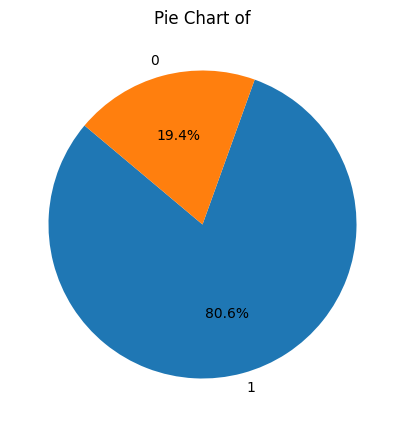

In [81]:
data_counts = y_train.value_counts()

# Plotting a pie chart
plt.figure(figsize=(5, 5))
plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of')
plt.show()

In [82]:
# Undersample majority class by half
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_rus, y_train_rus)

In [83]:
data = y_train.value_counts()
print(data)

loan_status
1    225328
0     54205
Name: count, dtype: int64


In [84]:
data_counts = y_train_resampled.value_counts()
print(data_counts)

loan_status
0    108410
1    108410
Name: count, dtype: int64


In [85]:
# Hyper Paramaters:
# n estimator (value to be determined by using a for loop while checking  accuracy score)
# bootstrap value true (to validate test result by using selecting random data)
# criterion value gini (Computational Efficiency as we have a large dataset and is less sensitive to outliers)
# max depth value none( to use all variables as it is currently not overfitting)
# max features value all/auto (use all to diversify tree, create more robust)

classes = [0, 1]  # Replace with your actual class labels
costs = {'0': 141000, '1': 1}  # Assign higher cost to the minority class

# Calculate class weights based on costs and prior probabilities
class_counts = y.value_counts()
class_weights = {
    class_: (cost * len(y_train_resampled)) / (len(y_train_resampled) - sum(costs.values()) + cost)
    for class_, cost in zip(classes, costs.values())
}

# Create a cost-sensitive random forest classifier
clf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='gini', max_depth=None, class_weight=class_weights, random_state=0)
# clf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='gini', max_depth=None, random_state=0)

# Train the classifier on the training set
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_validation = clf.predict(X_validation)

# Evaluate the accuracy on the validation set
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f'Validation Accuracy: {accuracy_validation}')

# Make predictions on the test set
y_pred_test = clf.predict(X_test)

# Evaluate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test}')

print(f'class weight {class_weights}')


Validation Accuracy: 0.7599164329460248
Test Accuracy: 0.757541068055635
class weight {0: 141000.6503120114, 1: 2.8596676338696914}


In [90]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix\n", cm)

Confusion Matrix
 [[ 2254  4558]
 [ 3914 24216]]


In [91]:
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

 Charged Off       0.37      0.33      0.35      6812
  Fully Paid       0.84      0.86      0.85     28130

    accuracy                           0.76     34942
   macro avg       0.60      0.60      0.60     34942
weighted avg       0.75      0.76      0.75     34942



In [88]:
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred_test)
print("Precision:", precision)

recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

specificity = TN / (TN + FP)
print("Specificity:", specificity)

f1 = f1_score(y_test, y_pred_test)
print("F1 Score:", f1)

Accuracy: 0.757541068055635
Precision: 0.8415931048863557
Recall: 0.8608602915037327
Specificity: 0.3308866705813271
F1 Score: 0.8511176718684098


AUC Score: 0.676933261058933


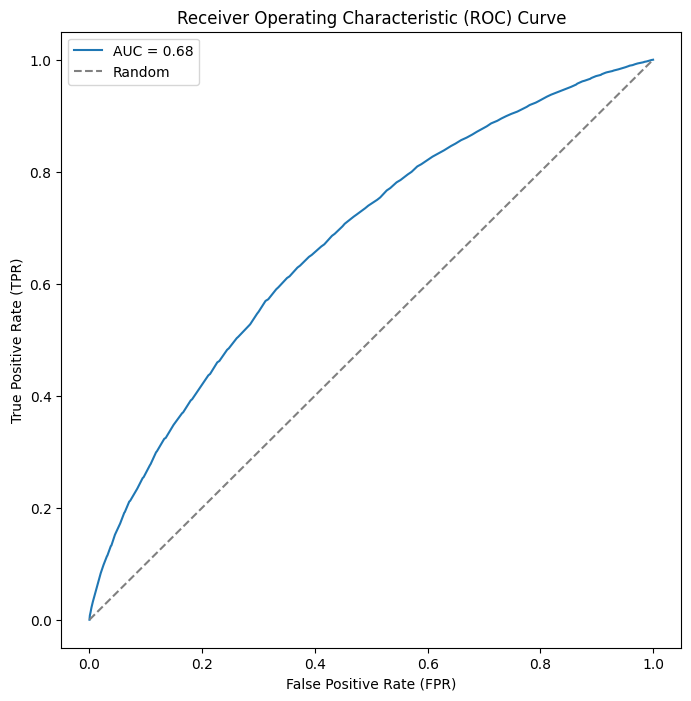

In [92]:
# Assuming you have the predicted probabilities for the positive class
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_test)
print("AUC Score:", auc_score)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

# is 69 auc score good what does it mean, what can i do to increase it?